In [1]:
# imports
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings('ignore')
#%matplotlib qt
%matplotlib inline

In [2]:
def parse_profiles_sea_and_sun(md_files, profiles, bathy):
    data = {}
    for i, profile in tqdm(enumerate(profiles)):
        #i = int(md['profile']['Profile name'][1:]) - 1
        #xsc = int(md['profile']['X Coordinate (CH1903)']) + int(2e6)
        #ysc = int(md['profile']['Y Coordinate (CH1903)']) + int(1e6)
        #total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        with open(profile, encoding='latin1', errors='ignore') as f:
            lines = f.readlines()

        for l in range(len(lines)):
            if "Lines :" in lines[l]:
                break

        columns = lines[l + 2].replace(";", "").split()[1:]
        df = pd.read_csv(profile, sep='\s+', header=None, skiprows=l+5, names=columns, engine='python', encoding='cp1252')

        # select downcast
        bottom_idx = np.argmax(df['Press'])
        df = df[:bottom_idx]

        # remove air
        df = df[df['Press'] > 0]

        data[i] = {
            #'name': md['profile']['Profile name'], 
            'name': os.path.basename(profile),
            'press': df['Press'].values, 
            'temp': df['Temp'].values,
            'd_oxygen_conc': df['DO_mg'].values * (1000/32),
            #'total_depth': total_depth
        }

    return data

def plot_profiles(data, dp, var, color):
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(25, 5), sharex=True, sharey=True)

    for i, dat in data.items():
        ax[i].plot(dat[var], dat[dp], c=color)
        ax[i].set_title(dat['name'])

        if dp == 'depth':
            ax[i].axhline(dat['total_depth'], color='gray', linestyle='--')
        
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    if dp == 'depth':
        ax[0].set_ylabel('Depth (m)')
    elif dp == 'press':
        ax[0].set_ylabel('Pressure (dbar)')

    if var == 'temp':
        fig.supxlabel('Temperature (°C)')
    elif var == 'd_oxygen_conc':
        fig.supxlabel('Dissolved Oxygen Concentration (umol/L)')

    ax[0].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [3]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [4]:
root = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/CTD/'
data_dir = '20251219/L0'

In [5]:
dpath = os.path.join(root, data_dir)
md_files = glob(os.path.join(dpath, '*.meta'))
profiles = glob(os.path.join(dpath , '*.TOB'))

In [6]:
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)

0it [00:00, ?it/s]

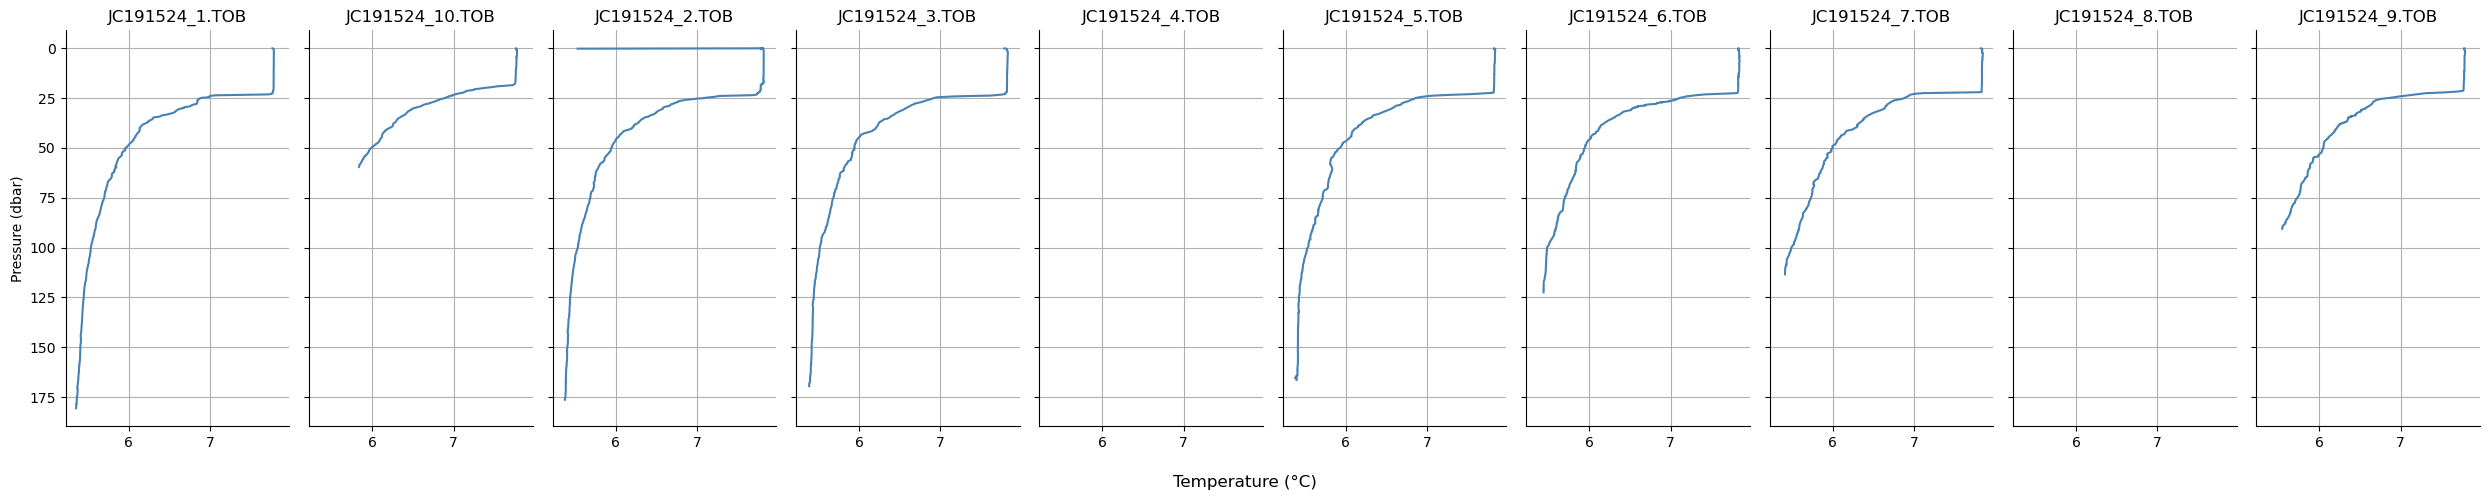

In [8]:
plot_profiles(data, 'press', 'temp', 'steelblue')

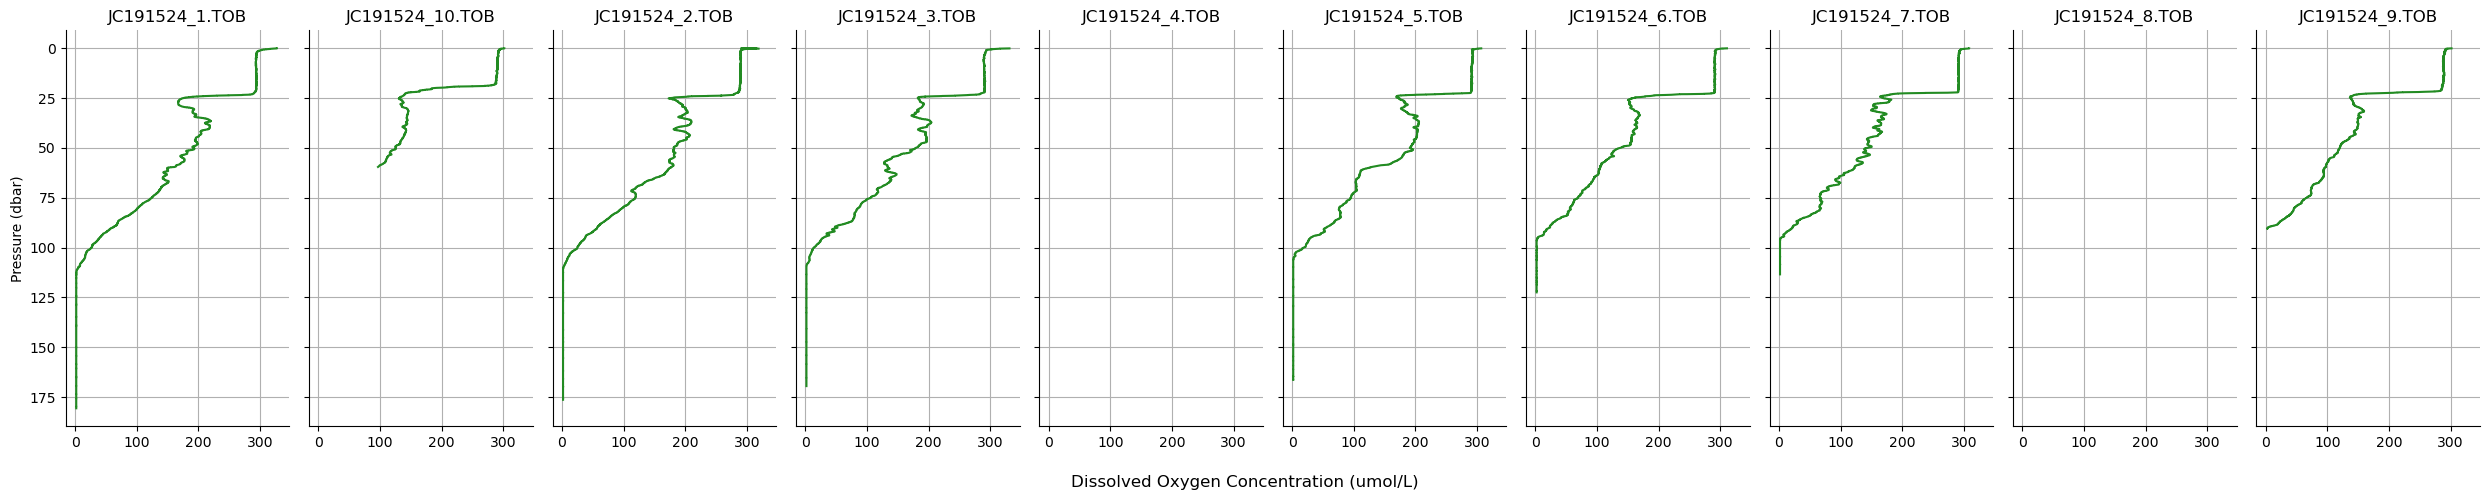

In [9]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')